### GMM 을 이용한 붓꽃 데이터 셋 클러스터링

In [1]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 보다 편리한 데이타 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

**GaussianMixture를 이용하여 붓꽃 데이터 군집화**

In [2]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 클러스터링 결과를 irisDF 의 'gmm_cluster' 컬럼명으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels


# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인. 
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       0              50
1       2              45
        1               5
2       1              50
Name: count, dtype: int64


**붓꽃 데이터 K-Means 군집화 결과**

In [3]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

**클러스터링 결과를 시각화하는 함수 생성**

In [4]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

**GMM군집화와 K-Means군집화를 비교하기 위해 타원형으로 늘어선 임의의 데이터 세트를 생성**

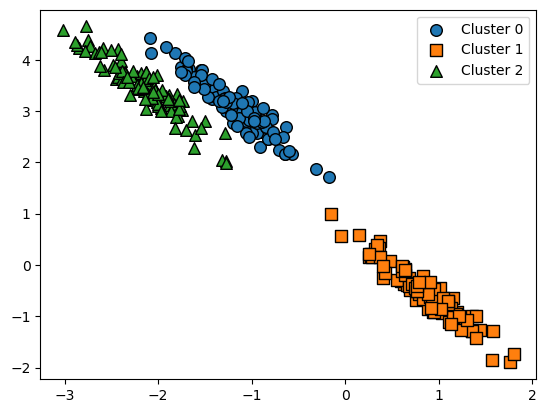

In [5]:
from sklearn.datasets import make_blobs

# make_blobs() 로 300개의 데이터 셋, 3개의 cluster 셋, cluster_std=0.5 을 만듬. 
X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 셋을 생성하기 위해 변환함. 
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
# feature 데이터 셋과 make_blobs( ) 의 y 결과 값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y
# 생성된 데이터 셋을 target 별로 다른 marker 로 표시하여 시각화 함. 
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)


**K-Means 군집화 수행**

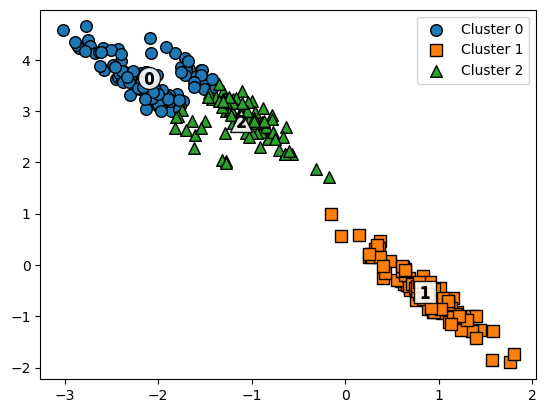

In [6]:
# 3개의 Cluster 기반 Kmeans 를 X_aniso 데이터 셋에 적용 
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label',iscenter=True)

**GMM 군집화 수행**

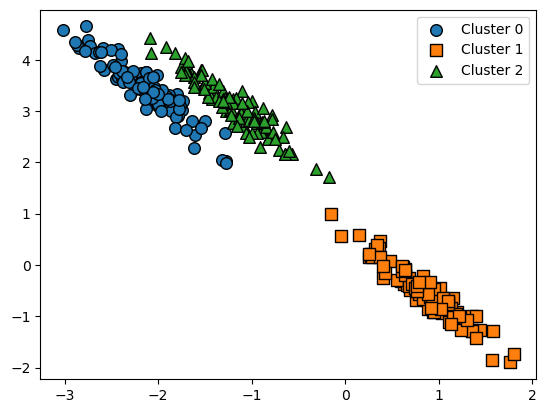

In [7]:
# 3개의 n_components기반 GMM을 X_aniso 데이터 셋에 적용 
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정. 
visualize_cluster_plot(gmm, clusterDF, 'gmm_label',iscenter=False)


**GMM과 K-Means 군집화 결과 비교**

In [8]:
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: count, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: count, dtype: int64


### DBSCAN 적용하기 – 붓꽃 데이터 셋

In [9]:
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 보다 편리한 데이타 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target
irisDF.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


**eps 0.6 min_samples=8 로 DBSCAN 군집화 적용**

In [10]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: count, dtype: int64


In [11]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

**PCA 2개 컴포넌트로 기존 feature들을 차원 축소 후 시각화**

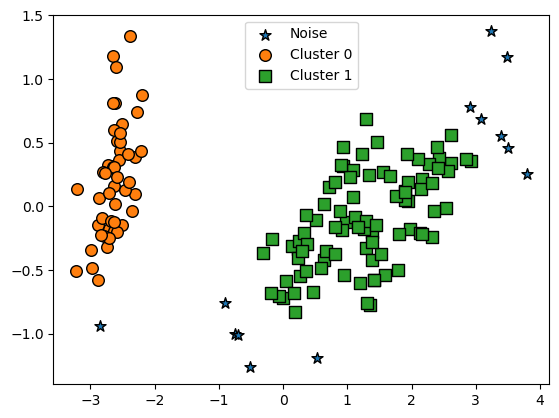

In [12]:
from sklearn.decomposition import PCA
# 2차원으로 시각화하기 위해 PCA n_componets=2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)
# visualize_cluster_2d( ) 함수는 ftr1, ftr2 컬럼을 좌표에 표현하므로 PCA 변환값을 해당 컬럼으로 생성
irisDF['ftr1'] = pca_transformed[:,0]
irisDF['ftr2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

**eps의 크기를 증가 한 후 노이즈 확인**

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: count, dtype: int64


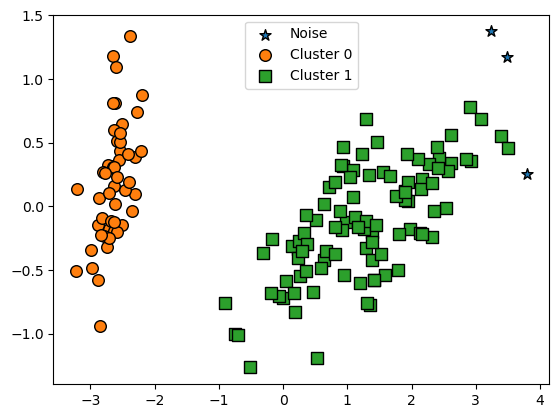

In [13]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)


**min_samples의 크기를 증가 후 노이즈 확인**

target  dbscan_cluster
0        0                48
        -1                 2
1        1                44
        -1                 6
2        1                36
        -1                14
Name: count, dtype: int64


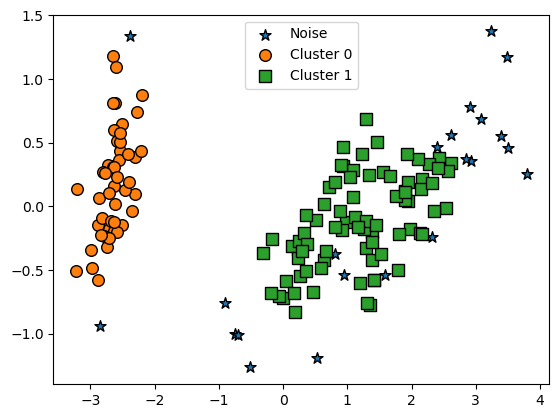

In [14]:
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)
visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

### DBSCAN 적용하기 – make_circles() 데이터 세트

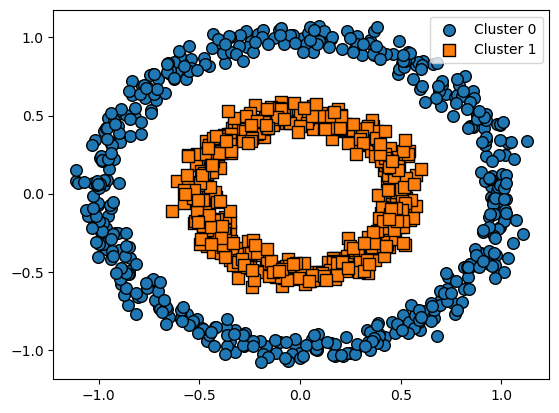

In [15]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=0, factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

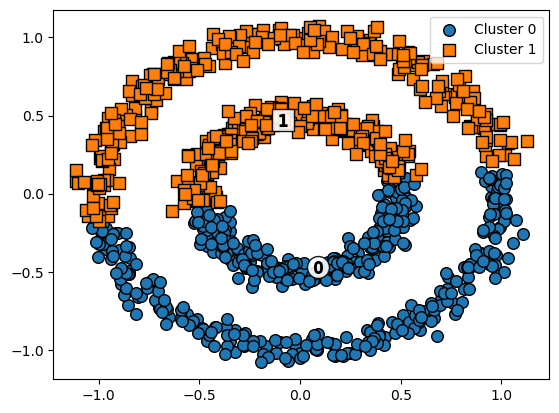

In [16]:
# KMeans로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
clusterDF['kmeans_cluster'] = kmeans_labels

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)

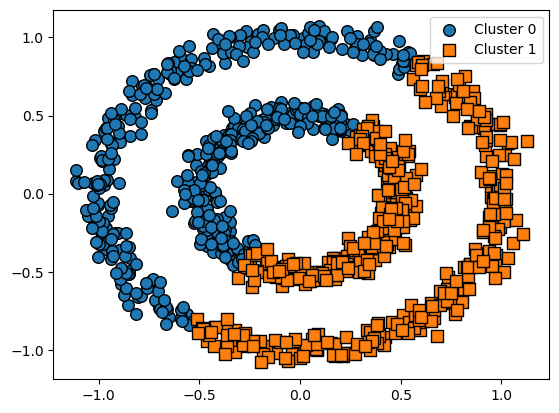

In [17]:
# GMM으로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit(X).predict(X)
clusterDF['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)


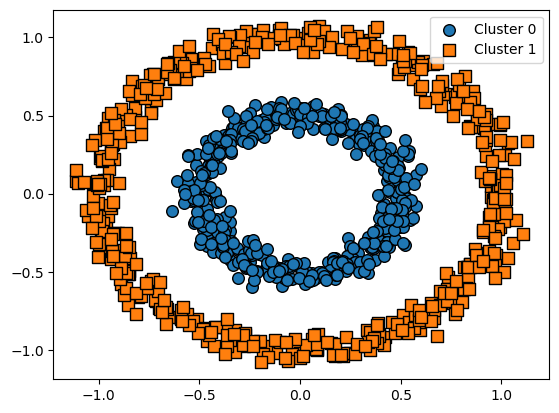

In [18]:
# DBSCAN으로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_labels

visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)

### 데이터 셋 로딩과 데이터 클린징

In [19]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel(io='Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [20]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


**반품이나 CustomerID가 Null인 데이터는 제외, 영국 이외 국가의 데이터는 제외**

In [21]:
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [22]:
retail_df['Country'].value_counts()[:5]

Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: count, dtype: int64

In [23]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


### RFM 기반 데이터 가공

**구매금액 생성**

In [24]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [25]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

CustomerID
17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: count, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [26]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

**고객 기준으로 Recency, Frequency, Monetary가공**

In [27]:
# DataFrame의 groupby() 의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 컬럼의 max() 에서 데이터 가공
# Frequency는 InvoiceNo 컬럼의 count() , Monetary value는 sale_amount 컬럼의 sum()
aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'sale_amount':'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 컬럼값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


**Recency를 날짜에서 정수형으로 가공**

In [28]:
cust_df['Recency'].max()

Timestamp('2011-12-09 12:49:00')

In [29]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 컬럼 건수는 ',cust_df.shape)
cust_df.head(3)

cust_df 로우와 컬럼 건수는  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


### RFM 기반 고객 세그먼테이션

**Recency, Frequency, Monetary 값의 분포도 확인**

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

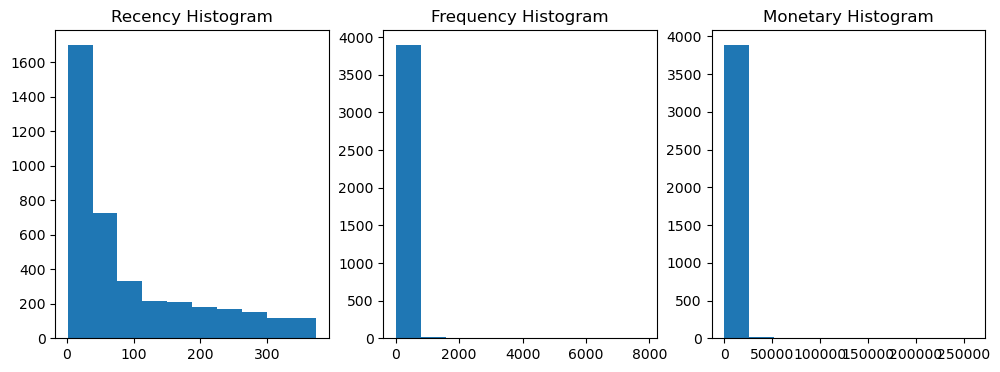

In [30]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

In [31]:
cust_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


**K-Means로 군집화 후에 실루엣 계수 평가**

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.592


**K-Means 군집화 후에 실루엣 계수 및 군집을 시각화**

In [33]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성  
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [34]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_9852\3186299039.py:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
C:\Users\PC\AppData\Local\Temp\ipykernel_9852\3186299039.py:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\


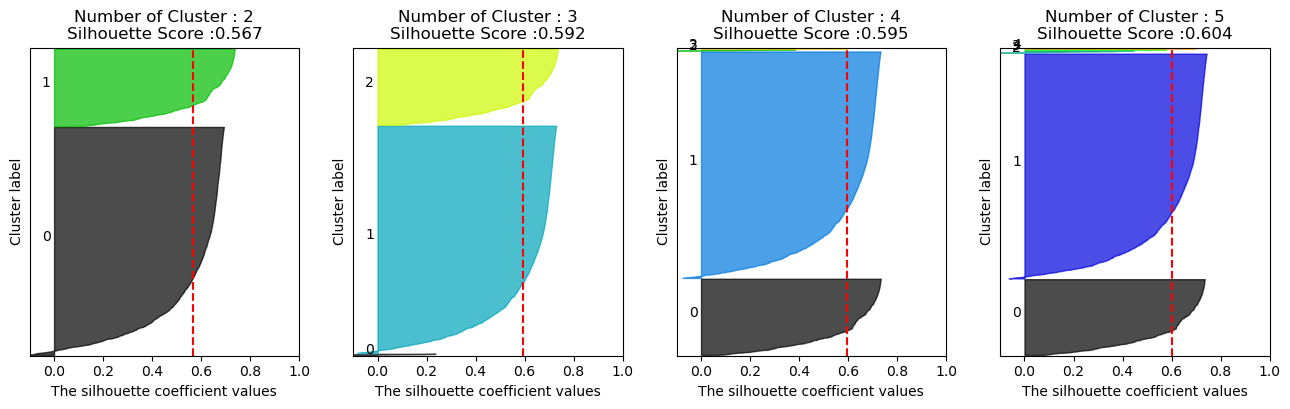

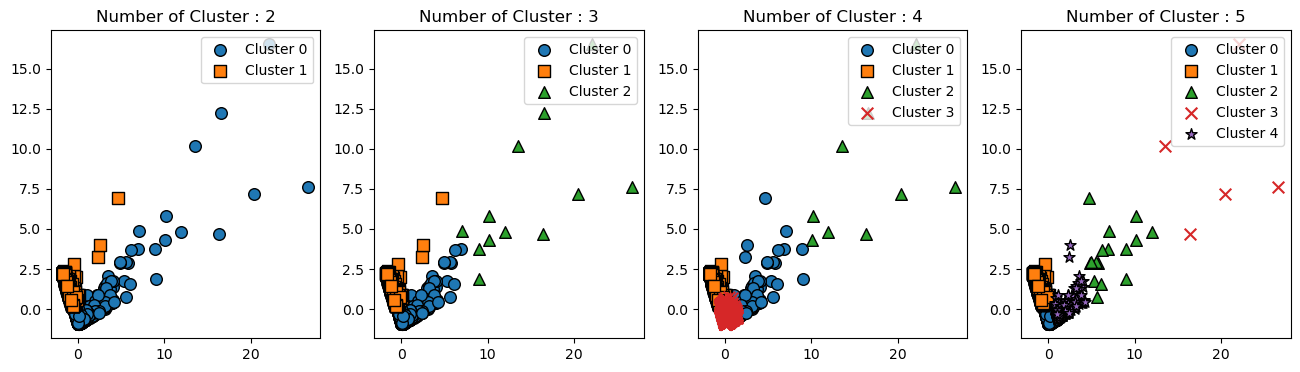

In [35]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

**로그 변환 후 재 시각화**

In [36]:
### Log 변환을 통해 데이터 변환
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequecny, Monetary 컬럼에 np.log1p() 로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))


실루엣 스코어는 : 0.303


C:\Users\PC\AppData\Local\Temp\ipykernel_9852\3186299039.py:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
C:\Users\PC\AppData\Local\Temp\ipykernel_9852\3186299039.py:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\


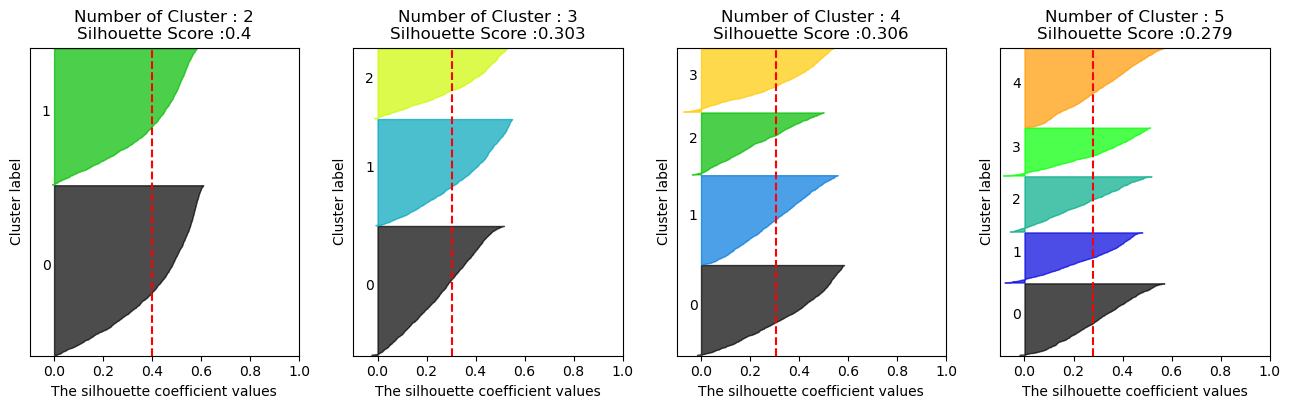

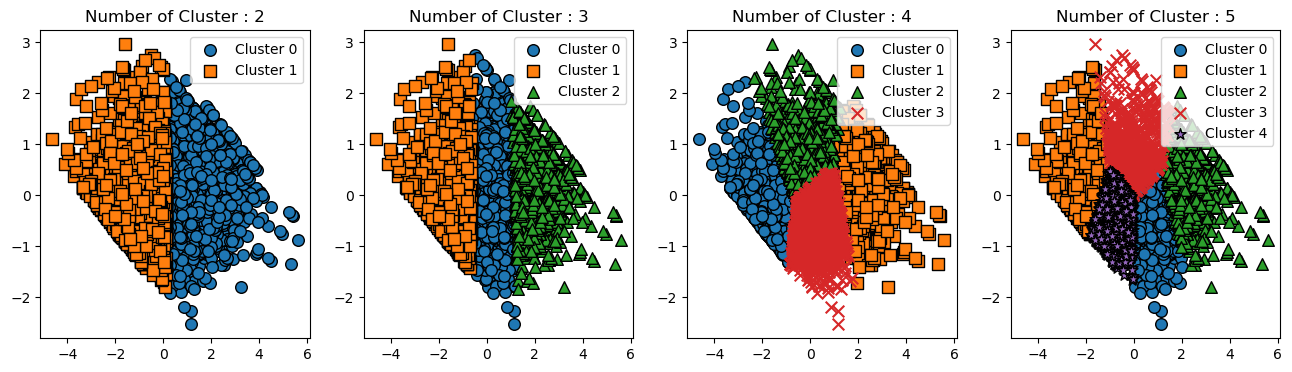

In [37]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)